## Exploring Rossmann Drug Store Sales Data

In [19]:
import pandas as pd

data = pd.read_csv('../../assets/dataset/rossmann.csv', skipinitialspace=True, low_memory=False)

Because we are most interested in the `Date` column that contains the date of sales for each store, we will make sure to process that as a `DateTime` type, and make that the index of our dataframe.

In [20]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data['Year'] = data.index.year
data['Month'] = data.index.month

In [21]:
store1_data = data[data.Store == 1]

### Data Exploration and MINEing

To compare sales on holidays, we can compare the sales using box-plots, which allows us to compare the distribution of sales on holidays against all other days.  On state holidays, the store is closed (and as a nice sanity check there are 0 sales), and on school holidays the sales are relatively similar.

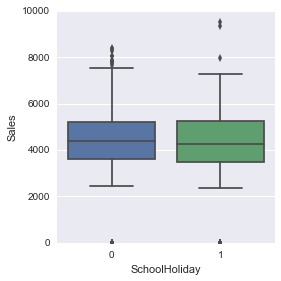

In [22]:
import seaborn as sb
%matplotlib inline

sb.factorplot(
    x='SchoolHoliday',
    y='Sales',
    data=store1_data, 
    kind='box'
)

> Check: See if there is a difference affecting sales on promotion days.

In [6]:
# TODO

Lastly, we want to identify larger-scale trends in our data. How did sales change from 2014 to 2015? Were there any particularly interesting outliers in terms of sales or customer visits?

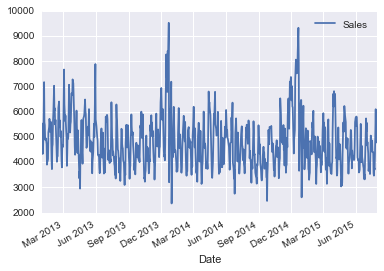

In [6]:
# Filter to days store 1 was open
store1_open_data = store1_data[store1_data.Open==1]
store1_open_data[['Sales']].plot()

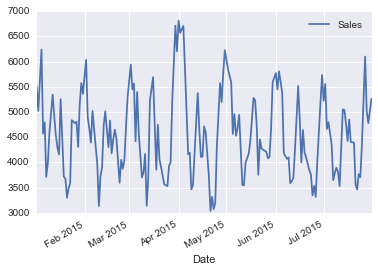

In [10]:
store1_data_2015 = store1_data['2015']
store1_data_2015[
    store1_data_2015.Open==1
][['Sales']].plot()

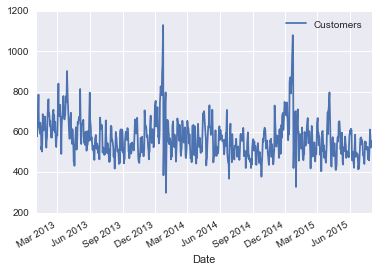

In [8]:
store1_open_data[['Customers']].plot()

In pandas, we can compute rolling average using the `pd.rolling_mean` or `pd.rolling_median` functions.

### Data REFINING Using Time Series Statistics

### Autocorrelation

To measure how much the sales are correlated with each other, we want to compute the _autocorrelation_ of the 'Sales' column. In pandas, we do this we with the `autocorr` function:

`autocorr` takes one argument, the `lag` which is how many prio data points should be used to compute the correlation. If we set the `lag` to 1, we compute the correlation between every point and the point directly preceding it. Setting `lag` to 10 computes the correlation between every point and the point 10 days earlier.

In [9]:
data['Sales'].resample('D').mean().autocorr(lag=1)

-0.025858276006383588

In [11]:
data['Customers'].resample('D').mean().autocorr(lag=1)

-0.095131583909775344

### Rolling Averages

If we want to investigate trends over time in sales, as always, we will start by computing simple aggregates.  What were the mean and median sales for each month and year?

In Pandas, this is performed using the `resample` command, which is very similar to the `groupby` command. It allows us to group over different time intervals.

We can use `data.resample` and provide as arguments:
    - The level on which to roll-up to, 'D' for day, 'W' for week, 'M' for month, 'A' for year
    - What aggregation to perform: 'mean', 'median', 'sum', etc.

In [12]:
data[['Sales']].resample('M').apply(['median', 'mean']).head()

Sales             
            median         mean
Date                           
2013-01-31  5194.0  5211.555578
2013-02-28  5421.5  5494.371397
2013-03-31  5844.0  5820.349168
2013-04-30  5464.0  5483.749836
2013-05-31  5585.0  5364.127383

In [13]:
data[['Sales']].resample('A').apply(['median', 'mean']).head()

Sales             
           median         mean
Date                          
2013-12-31   5598  5658.533675
2014-12-31   5794  5833.290704
2015-12-31   5916  5878.245380

While identifying the monthly averages is useful, we often want to compare the sales data of a date to a smaller window. To understand holidays sales, we don't want to compare late December with the entire month, but perhaps with a few days surrounding it. We can do this using rolling averages.

In pandas, we can compute rolling average using the `pd.rolling_mean` or `pd.rolling_median` functions.

In [11]:
data[['Sales']].resample('D').mean().rolling(window=3, center=True).mean().head()

,Sales
Date,
2013-01-01,NaN
2013-01-02,4004.475720
2013-01-03,5960.120478
2013-01-04,5661.694170
2013-01-05,3807.010762


`rolling_mean` (as well as `rolling_median`) takes these important parameters:
    - the first is the series to aggregate
    - `window` is the number of days to include in the average
    - `center` is whether the window should be centered on the date or use data prior to that date
    - `freq` is on what level to roll-up the averages to (as used in `resample`). Either `D` for day, `M` for month or `A` for year, etc.

Instead of plotting the full timeseries, we can plot the rolling mean instead, which smooths random changes in sales as well as removing outliers, helping us identify larger trends.

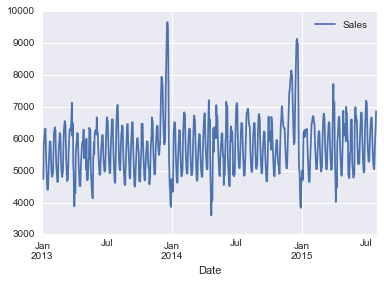

In [17]:
data[['Sales']].resample('D').mean().rolling(window=7, center=True).mean().plot()

### Pandas Window functions
Pandas `rolling_mean` and `rolling_median` are only two examples of Pandas window function capabilities. Window functions are operate on a set of N consecutive rows (a window) and produce an output.

In addition to `rolling_mean` and `rolling_median`, there are `rolling_sum`, `rolling_min`, `rolling_max`... and many more.

Another common one is `diff`, which takes the difference over time. `pd.diff` takes one arugment, `periods`, which is how many rows prior to use for the difference.


In [14]:
data['Sales'].diff(periods=1).head()

Date
2015-07-31       NaN
2015-07-31     801.0
2015-07-31    2250.0
2015-07-31    5681.0
2015-07-31   -9173.0
Name: Sales, dtype: float64

### Pandas expanding functions

In addition to the set of `rolling_*` functions, Pandas also provides a similar collection of `expanding_*` functions, which, instead of using a window of N values, use all values up until that time.

In [15]:
# computes the average sales, from the first date _until_ the date specified.
data[['Sales']].resample('D').mean().expanding().mean().head()


,Sales
Date,
2013-01-01,87.284560
2013-01-02,3160.157527
2013-01-03,4004.475720
2013-01-04,4491.911499
2013-01-05,4661.079513


## Exercises

> Plot the distribution of sales by month and compare the effect of promotions

In [ ]:
store1_data

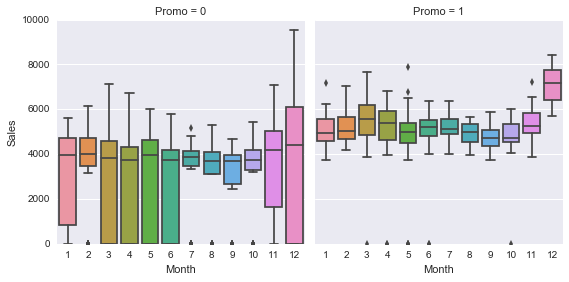

In [24]:
#data[['Sales']].resample('M').mean().rolling(window=7, center=True).mean().plot()
import seaborn as sb
%matplotlib inline

sb.factorplot(
    col='Promo',
    x='Month',
    y='Sales',
    data=store1_data, 
    kind='box'
)

> Are sales more correlated with the prior date, a similar date last year, or a similar date last month?

In [25]:
data['Sales'].resample('D').mean().autocorr(lag=1)

-0.025858276006383588

In [27]:
data['Sales'].resample('M').mean().autocorr(lag=1)

0.13808548739228391

In [26]:
data['Sales'].resample('A').mean().autocorr(lag=1)

0.99999999999999989

> Plot the 15 day rolling mean of customers in the stores

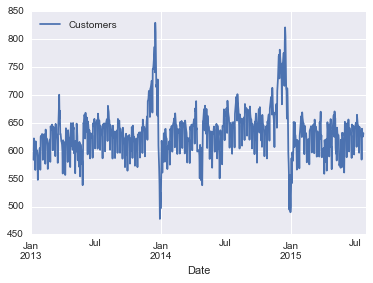

In [42]:
data[['Customers']].resample('D').mean().rolling(window=15, center=True).mean().plot()
#.head(30)

> Identify the date with largest drop in sales from the same date in the previous month

In [66]:
#data['Sales'].resample('D').mean().autocorr(lag=1)
data['Sales'].resample('M').diff(periods=1).argmin()
#df.groupby('id')['value'].nlargest(2)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  from ipykernel import kernelapp as app


Timestamp('2014-01-31 00:00:00', offset='M')

Date
2013-01-31            NaN
2013-02-28     282.815818
2013-03-31     325.977772
2013-04-30    -336.599333
2013-05-31    -119.622452
2013-06-30      38.035576
2013-07-31     639.899300
2013-08-31    -312.488211
2013-09-30    -406.585618
2013-10-31     106.270357
2013-11-30     435.342827
2013-12-31     839.016525
2014-01-31   -1271.742341
2014-02-28     299.215713
2014-03-31    -146.834200
2014-04-30     231.736021
2014-05-31    -183.322800
2014-06-30      48.855655
2014-07-31     317.877193
2014-08-31    -349.982129
2014-09-30     215.682776
2014-10-31    -199.539150
2014-11-30     513.684783
2014-12-31     794.032795
2015-01-31   -1220.534590
2015-02-28     -42.451326
2015-03-31     238.833591
2015-04-30     -32.272553
2015-05-31    -444.735576
2015-06-30     727.081974
2015-07-31     -56.498465
Freq: M, Name: Sales, dtype: float64

> Compute the total sales up until Dec. 2014

In [81]:
data[['Sales']].resample('M').mean().expanding().sum()['2014-11']

,Sales
Date,
2014-11-30,131104.577483


> When were the largest differences between 15-day moving/rolling averages?
> HINT: Using `rolling_mean` and `diff`

In [87]:
#data['Sales'].resample('D').rolling_mean().diff(periods=1).argmin()
data[['Sales']].resample('D').rolling(window=15, center=True).mean().diff(periods=1)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  from ipykernel import kernelapp as app


,Sales
Date,
2013-01-01,NaN
2013-01-02,NaN
2013-01-03,NaN
2013-01-04,NaN
2013-01-05,NaN
2013-01-06,NaN
2013-01-07,NaN
2013-01-08,NaN
2013-01-09,310.654572
